# Reinforcement Learning

In this notebook we use PyTorch to train a Deep Q-Learning (DQN) agent on the [LunarLander-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/) task from [Gymnasium](https://gymnasium.farama.org/).

# Setup

In [1]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d] --quiet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,068 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
G

In [2]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque
import gc

import base64
import json
import imageio
import IPython
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Explore the Environment

In [4]:
env = gym.make("LunarLander-v3", render_mode='rgb_array')

print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Actions: Discrete(4)


In [5]:
class RandomAgent(object):

    def __init__(self):
        pass

    def act(self, state, greedy=None):
        return torch.randint(0, 4, (1,)).item()

Visualizing the random policy.

In [6]:
random_agent = RandomAgent()

create_policy_eval_video(env, random_agent, 'random_policy', num_episodes=5)

# Replay Memory

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size
        transition_tuple = ('state', 'action', 'reward', 'next_state', 'done')
        self.experience = namedtuple('Experience', transition_tuple)

    def push(self, state, action, next_state, reward, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self):
        sample = random.sample(self.memory, self.batch_size)
        states = torch.from_numpy(np.vstack([s.state for s in sample if s is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([s.action for s in sample if s is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([s.reward for s in sample if s is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([s.next_state for s in sample if s is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([s.done for s in sample if s is not None]).astype(np.uint8)).float().to(device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

# Deep Q-Network

In [8]:
class QNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(QNetwork, self).__init__()
        self.q_net = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.q_net(x)
        return x

# Agent

In [9]:
class Agent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        self.policy_net = q_network.to(device)
        self.target_net = copy.deepcopy(q_network).to(device)
        self.memory = memory(params['BUFFER_SIZE'], params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'], amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        # Set steps counter to zero
        self.steps_done = 0

    def step(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)
        self.steps_done += 1
        if len(self.memory) > self.memory.batch_size:
            states, actions, rewards, next_states, dones = self.memory.sample()
            self.learn(states, actions, rewards, next_states, dones)
        if self.steps_done % self.update_rate == 0:
            self.soft_update()


    def act(self, state, greedy=False):
        eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(-1. * self.steps_done / self.eps['DECAY'])
        if greedy or random.random() > eps_threshold:
            self.policy_net.eval()
            with torch.no_grad():
                action = self.policy_net(state).argmax().item()
            self.policy_net.train()
        else:
            action = torch.randint(0, 4, (1,)).item()
        return action

    def learn(self, states, actions, rewards, next_states, dones):
        pred_q_vals = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
          expected_q_vals = self.target_net(next_states).max(1).values.reshape(-1, 1)
        target_q_vals = rewards + (self.gamma * expected_q_vals * (1 - dones))
        loss = self.criterion(pred_q_vals, target_q_vals)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def soft_update(self):
        with torch.no_grad():
          for policy_param, target_param in zip(self.policy_net.parameters(), self.target_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

# Training

In [10]:
params = {
    'UPDATE_RATE': 2 ,    # how often to update the network
    'BUFFER_SIZE': int(1e4) ,    # size of the replay buffer
    'BATCH_SIZE': 128 ,     # number of experiences sampled from memory
    'GAMMA': 0.99 ,          # discount factor
    'EPS_START': .9 ,      # starting value of epsilon
    'EPS_END': 0.05 ,        # final value of epsilon
    'EPS_DECAY': int(1e3) ,      # rate of exponential decay of epsilon
    'TAU': 5e-3 ,            # update rate of the target network
    'LR': 1e-3              # learning rate of the optimizer
}

env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

sum_of_rewards = list()

optimizer = optim.Adam
criterion = nn.MSELoss()

agent = Agent(QNetwork(n_observations, n_actions), ReplayMemory, optimizer, criterion, params)

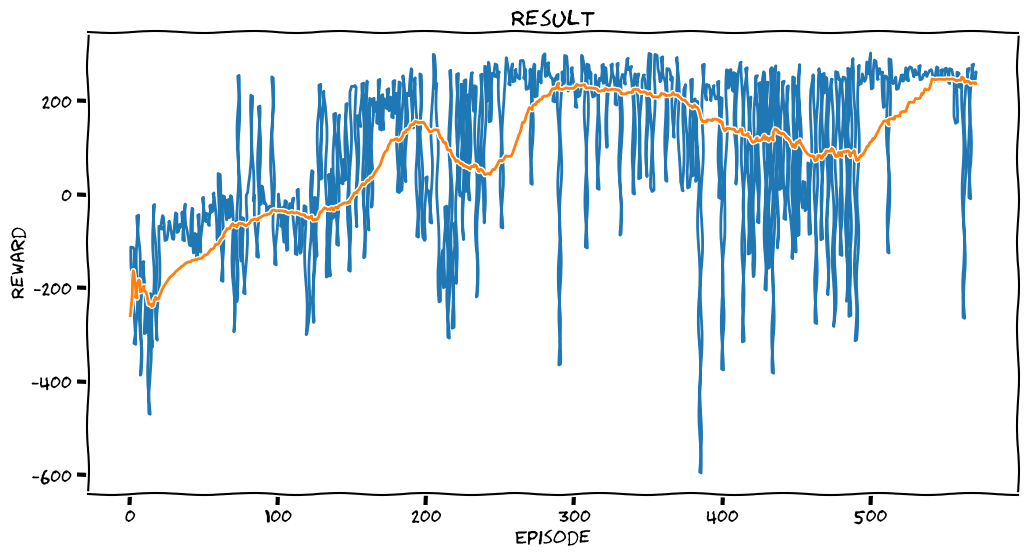

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [12]:
num_episodes = 580

for i_episode in range(1, num_episodes + 1):
    gc.collect()
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward, done = 0, False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        reward = torch.as_tensor(reward)
        next_state = torch.as_tensor(next_state).to(device)
        termination = terminated | truncated
        done = termination
        agent.step(state, action, next_state, reward, done)
        state = next_state

    # Update and plot rewards
    sum_of_rewards.append(episode_reward)
    plot_rewards(sum_of_rewards)
    # Save model every 100 episodes (change the rate if needed)
    if i_episode % 100 == 0:
        path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
        agent.save(path)
        save_progress(sum_of_rewards, path)

plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

# Evaluate the Model

In [13]:
def evaluate_policy(env, agent, num_episodes=10):
    sum_of_rewards = np.zeros(10)
    for episode in range(num_episodes):
      state, _ = env.reset()
      while True:
        action = agent.act(torch.as_tensor(state).to(device), greedy=True)
        next_state, reward, terminate, truncated, _ = env.step(action)
        sum_of_rewards[episode] += reward
        state = torch.as_tensor(next_state).to(device)
        if terminate or truncated:
          break

    return sum_of_rewards.mean(), sum_of_rewards.std()

In [15]:
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = 184.06 +/- 79.2872


In [17]:
env = gym.make("LunarLander-v3", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)